# ***NEGOTIATION STRATEGY RECOMMENDATION SYSTEM***
> Utilizes an individua's Big Five personality traits (OCEAN) to recommend Negotiation Strategies using the [CaSiNo](https://raw.githubusercontent.com/kushalchawla/CaSiNo/refs/heads/main/data/casino.json) dataset, taking into account the following information in every dialogue: -


1.   Participant Information (Demographics, Personality Attributes, Preference Order, Arguments for needing/not needing a specific item) 
2.   Negotiation Dialogue (Additionally includes the usage of four emoticons: Joy, Sadness, Anger, Surprise)
3.   Negotiation Outcome (Points scored, Satisfaction, Opponent Likeness)
4.   Strategy Annotations (Utterance-level annotations for various negotiation strategies used by participants)


In [1]:
# Downloading CaSiNo dataset from GitHub repository
!wget https://raw.githubusercontent.com/kushalchawla/CaSiNo/refs/heads/main/data/casino.json

--2025-05-07 21:00:16--  https://raw.githubusercontent.com/kushalchawla/CaSiNo/refs/heads/main/data/casino.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4300019 (4.1M) [text/plain]
Saving to: ‘casino.json.11’

casino.json.11      100%[===================>]   4.10M  --.-KB/s    in 0.04s   

2025-05-07 21:00:17 (95.7 MB/s) - ‘casino.json.11’ saved [4300019/4300019]



In [2]:
# Loading the dataset as a JSON object
import json
with open('casino.json') as f:
  data = json.load(f)

# Printing the first dialogue from the dataset
print(json.dumps(data[0], indent=2))

{
  "dialogue_id": 0,
  "chat_logs": [
    {
      "text": "Hello! \ud83d\ude42 Let's work together on a deal for these packages, shall we? What are you most interested in?",
      "task_data": {},
      "id": "mturk_agent_1"
    },
    {
      "text": "Hey! I'd like some more firewood to keep my doggo warm. What do you need?",
      "task_data": {},
      "id": "mturk_agent_2"
    },
    {
      "text": "I need firewood as well. We have a large group consisting of mostly senior citizens, including my grandma, so we'd like the firewood to keep everyone warm.",
      "task_data": {},
      "id": "mturk_agent_1"
    },
    {
      "text": "I see. \ud83d\ude2e What are you least interested in?",
      "task_data": {},
      "id": "mturk_agent_2"
    },
    {
      "text": "We can make do without extra water. Can we trade two waters for an extra firewood package and an extra food package?",
      "task_data": {},
      "id": "mturk_agent_1"
    },
    {
      "text": "We could do without t

In [3]:
def analyze_strategy_effectiveness(data):
    """Analyze which strategies lead to best outcomes for different personality types"""
    
    # Create mapping of personality traits to strategy success
    personality_strategy_success = []
    
    for dialogue in data:
        for participant_id, info in dialogue['participant_info'].items():
            # Get personality traits
            if 'personality' in info and 'big-five' in info['personality']:
                personality = info['personality']['big-five']
                
                # Get priorities
                if 'value2issue' in info:
                    priorities = {item: level for level, item in info['value2issue'].items()}
                    
                    # Get strategies used (from annotations)
                    strategies_used = {}
                    if 'annotations' in dialogue:
                        for utterance, strategy_labels in dialogue['annotations']:
                            # Check if this utterance belongs to this participant
                            for msg in dialogue['chat_logs']:
                                if msg['text'] == utterance and msg['id'] == participant_id:
                                    # Count strategy usage
                                    for strategy in strategy_labels.split(','):
                                        if strategy.strip():
                                            if strategy.strip() not in strategies_used:
                                                strategies_used[strategy.strip()] = 0
                                            strategies_used[strategy.strip()] += 1
                    
                    # Get outcome (points)
                    if 'outcomes' in info:
                        points = info['outcomes'].get('points_scored', 0)
                        
                        # Record data point
                        personality_strategy_success.append({
                            'personality': personality,
                            'priorities': priorities,
                            'strategies_used': strategies_used,
                            'points': points
                        })
    
    print(f"Extracted data from {len(personality_strategy_success)} participants")
    return personality_strategy_success

In [4]:
class NegotiationRecommender:
    def __init__(self, data):
        """Initialize the complete recommender system"""
        print("Initializing Negotiation Recommender...")
        # Analyze the dataset
        self.data = data
        self.strategy_effectiveness_data = analyze_strategy_effectiveness(data)
        
        # Initialize components
        self.strategy_recommender = StrategyRecommender(self.strategy_effectiveness_data)
        
        # Use the global classifier that's already trained
        global classifier
        self.strategy_classifier = classifier
        
        print("Negotiation Recommender initialized successfully!")
    
    def get_recommendations(self, personality, priorities, top_n=3):
        """Get strategy recommendations based on personality and priorities"""
        # Get strategy recommendations
        strategies = self.strategy_recommender.recommend_strategies(personality, priorities, top_n)
        
        # Enhance with examples
        for strategy in strategies:
            try:
                examples = self.strategy_classifier.get_strategy_examples(strategy['strategy'], n=2)
                strategy['examples'] = examples
            except Exception as e:
                print(f"Error getting examples for {strategy['strategy']}: {e}")
                strategy['examples'] = ["Example not available."]
        
        return strategies

In [5]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

class StrategyRecommender:
    def __init__(self, personality_strategy_data):
        self.data = personality_strategy_data
        self.personality_cols = ['extraversion', 'agreeableness', 'conscientiousness', 
                                'emotional-stability', 'openness-to-experiences']
        self.strategy_cols = ['small-talk', 'empathy', 'coordination', 'no-need', 
                             'elicit-pref', 'undervalue-partner', 'vouch-fairness', 
                             'self-need', 'other-need']
        self._prepare_data()
        self._build_model()
    
    def _prepare_data(self):
        """Prepare features and target for model"""
        # Create feature vectors
        X = []
        y = []
        
        for item in self.data:
            # Personality features
            personality_vector = [item['personality'].get(trait, 0) for trait in self.personality_cols]
            
            # Priority features (one-hot encoding)
            priority_vector = [0, 0, 0]  # [food_priority, water_priority, firewood_priority]
            for i, item_type in enumerate(['Food', 'Water', 'Firewood']):
                priority = item['priorities'].get(item_type, 'Medium')
                priority_vector[i] = {'High': 2, 'Medium': 1, 'Low': 0}[priority]
            
            # Combined features
            features = personality_vector + priority_vector
            X.append(features)
            
            # Target: points
            y.append(item['points'])

        self.X = np.array(X)
        self.y = np.array(y)
        
        # Printing feature vector examples
        print("\n=== Sample Feature Vectors (Personality + Priorities) ===")
        for i in range(min(3, len(self.X))):
            print(f"Sample {i+1}:")
            print(f"  Personality traits: {self.X[i][:5]}")  # First 5 values are personality
            print(f"  Priorities: {self.X[i][5:]}")  # Last 3 values are priorities
            print(f"  Associated points: {self.y[i]}")
        print("\n")
        
        # Calculate strategy effectiveness for different personality clusters
        self._calculate_strategy_effectiveness()

    def _calculate_strategy_effectiveness(self):
        """Calculate which strategies are most effective for different profiles"""
        import numpy as np
        from sklearn.cluster import KMeans

        # Create personality vectors for clustering
        personality_vectors = []
        for item in self.data:
            # Extract personality features
            personality_vector = [
                item['personality'].get(trait, 0) 
                for trait in self.personality_cols
            ]
            personality_vectors.append(personality_vector)
        
        # Cluster similar personality profiles (if we have enough data)
        if len(personality_vectors) > 20:
            kmeans = KMeans(n_clusters=min(8, len(personality_vectors) // 5))
            personality_clusters = kmeans.fit_predict(personality_vectors)
        else:
            # Not enough data for meaningful clustering -> Single cluster
            personality_clusters = np.zeros(len(personality_vectors))
        
        # Store cluster assignments with the data
        for i, item in enumerate(self.data):
            item['cluster'] = int(personality_clusters[i])
        
        # Calculate strategy effectiveness per cluster
        self.cluster_strategy_effectiveness = {}
        
        for item in self.data:
            cluster = item['cluster']
            if cluster not in self.cluster_strategy_effectiveness:
                self.cluster_strategy_effectiveness[cluster] = {
                    strategy: {'points': [], 'count': 0} 
                    for strategy in self.strategy_cols
                }
            
            # Record points for each strategy used
            for strategy, count in item['strategies_used'].items():
                if strategy in self.cluster_strategy_effectiveness[cluster] and count > 0:
                    self.cluster_strategy_effectiveness[cluster][strategy]['points'].append(item['points'])
                    self.cluster_strategy_effectiveness[cluster][strategy]['count'] += count

        # Calculate average points per strategy per cluster
        self.strategy_scores = {}
        for cluster, strategies in self.cluster_strategy_effectiveness.items():
            self.strategy_scores[cluster] = {}
            for strategy, data in strategies.items():
                if data['points']:
                    self.strategy_scores[cluster][strategy] = sum(data['points']) / len(data['points'])
                else:
                    self.strategy_scores[cluster][strategy] = 0
        
        print(f"Calculated strategy effectiveness for {len(self.cluster_strategy_effectiveness)} personality clusters")
    
    # def _calculate_strategy_effectiveness(self):
    #     """Calculate which strategies are most effective for different profiles"""
    #     self.strategy_effectiveness = {}
        
    #     # For simplicity, we'll use a straightforward approach
    #     # For each data point, record which strategies were used and points achieved
    #     for item in self.data:
    #         # Create a personality cluster key (simplistic approach)
    #         # In practice, you might use proper clustering
    #         personality_key = tuple(int(item['personality'].get(trait, 0) // 2) for trait in self.personality_cols)
            
    #         if personality_key not in self.strategy_effectiveness:
    #             self.strategy_effectiveness[personality_key] = {strategy: [] for strategy in self.strategy_cols}
            
    #         # Record points for each strategy used
    #         for strategy, count in item['strategies_used'].items():
    #             if strategy in self.strategy_effectiveness[personality_key] and count > 0:
    #                 self.strategy_effectiveness[personality_key][strategy].append(item['points'])

    def find_closest_cluster(self, personality):
        """Find the closest personality cluster for a given personality profile"""
        import numpy as np
        from sklearn.metrics.pairwise import cosine_similarity
        
        # Create personality vector
        personality_vector = np.array([
            personality.get(trait, 0) 
            for trait in self.personality_cols
        ]).reshape(1, -1)
        
        # Calculate similarity to each cluster centroid
        cluster_similarities = {}
        for cluster in self.cluster_strategy_effectiveness:
            # Calculate average personality vector for this cluster
            cluster_vectors = []
            for item in self.data:
                if item['cluster'] == cluster:
                    vector = [item['personality'].get(trait, 0) for trait in self.personality_cols]
                    cluster_vectors.append(vector)
            
            if cluster_vectors:
                centroid = np.mean(cluster_vectors, axis=0).reshape(1, -1)
                similarity = cosine_similarity(personality_vector, centroid)[0][0]
                cluster_similarities[cluster] = similarity
        
        # Find most similar cluster
        if cluster_similarities:
            return max(cluster_similarities, key=cluster_similarities.get)
        else:
            return 0  # Default to cluster 0 if no similarities found
    
    def _build_model(self):
        """Build the recommendation model"""
        # Use KNN for predicting points based on personality and priorities
        self.model = KNeighborsRegressor(n_neighbors=5)
        self.model.fit(self.X, self.y)
    
    def recommend_strategies(self, personality, priorities, top_n=3):
        """Recommend top strategies for given personality and priorities"""
        # Find closest personality cluster
        closest_cluster = self.find_closest_cluster(personality)
        
        # Get strategy effectiveness for this cluster
        if closest_cluster in self.strategy_scores:
            strategy_scores = self.strategy_scores[closest_cluster]
            
            # Adjust scores based on priorities
            adjusted_scores = dict(strategy_scores)
            
            # Prioritize self-need for high-priority items
            high_priority_item = next((item for item, prio in priorities.items() if prio == 'High'), None)
            if high_priority_item and 'self-need' in adjusted_scores:
                adjusted_scores['self-need'] *= 1.2  # Boost self-need strategy
            
            # Sort strategies by effectiveness
            sorted_strategies = sorted(
                adjusted_scores.items(), 
                key=lambda x: x[1], 
                reverse=True
            )
            
            # Return top N strategies
            recommendations = []
            for strategy, score in sorted_strategies[:top_n]:
                if score > 0:  # Only recommend strategies with positive scores
                    recommendations.append({
                        'strategy': strategy,
                        'expected_points': score,
                        'explanation': self._generate_explanation(strategy, personality, priorities)
                    })
            
            return recommendations
        else:
            # Fallback to general recommendations
            return [
                {
                    'strategy': 'small-talk',
                    'expected_points': 15.0,
                    'explanation': "Building rapport through casual conversation creates a positive atmosphere for negotiation."
                },
                {
                    'strategy': 'elicit-pref',
                    'expected_points': 14.5,
                    'explanation': "Understanding your partner's preferences helps identify mutually beneficial trades."
                },
                {
                    'strategy': 'self-need',
                    'expected_points': 14.0,
                    'explanation': "Clearly expressing your needs with personal context makes your position more convincing."
                }
            ]
    
    def _generate_explanation(self, strategy, personality, priorities):
        """Generate explanation for recommended strategy"""
        # Basic explanations based on strategy type
        explanations = {
            'small-talk': "Building rapport through casual conversation creates a positive atmosphere for negotiation.",
            'self-need': "Clearly expressing your needs with personal context makes your position more convincing.",
            'promote-coordination': "Explicitly finding mutually beneficial arrangements leads to better outcomes.",
            'vouch-fair': "Appealing to fairness can help justify your position in the negotiation.",
            'elicit-pref': "Understanding your partner's preferences helps identify mutually beneficial trades.",
            'showing-empathy': "Showing understanding for your partner's needs helps build trust and goodwill.",
            'other-need': "Negotiating on behalf of others' needs can make your requests seem less self-serving.",
            'no-need': "Indicating you don't need certain items can encourage reciprocity from your partner.",
            'uv-part': "Questioning your partner's need for certain items may lead them to concede more.",
            'non-strategic': "General conversation helps maintain a positive negotiation atmosphere."
        }
        
        # Add personality-specific context
        if strategy == 'small-talk' and personality.get('extraversion', 0) > 5:
            return explanations.get(strategy, "") + " This approach plays to your extraverted nature."
        elif strategy == 'showing-empathy' and personality.get('agreeableness', 0) > 5:
            return explanations.get(strategy, "") + " This aligns well with your agreeable personality."
        
        # Add priority-specific context
        high_priority_item = next((item for item, prio in priorities.items() if prio == 'High'), None)
        if strategy == 'self-need' and high_priority_item:
            return explanations.get(strategy, "") + f" Focus on explaining why you need {high_priority_item}."
        
        return explanations.get(strategy, "This strategy has proven effective for negotiators with similar personality traits.")

In [6]:
class StrategyClassifier:
    def __init__(self, data, model_path=None):
        """
        Initialize the BERT-based strategy classifier
        
        Args:
            data: The CaSiNo dataset
            model_path: Optional path to a pre-trained model
        """
        from transformers import BertTokenizer, BertForSequenceClassification
        import torch
        from sklearn.model_selection import train_test_split
        from tqdm.notebook import tqdm  # Use notebook-specific tqdm
        
        self.data = data
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        self.strategies = [
            'non-strategic', 
            'small-talk', 
            'self-need', 
            'promote-coordination', 
            'vouch-fair',            
            'elicit-pref',
            'showing-empathy',     
            'other-need',
            'no-need',
            'uv-part'                
        ]
        
        # Strategy to index mapping
        self.strategy2idx = {strategy: idx for idx, strategy in enumerate(self.strategies)}
        self.idx2strategy = {idx: strategy for idx, strategy in enumerate(self.strategies)}
        
        if model_path:
            print(f"Loading pre-trained model from {model_path}")
            self.model = BertForSequenceClassification.from_pretrained(model_path)
        else:
            print("Initializing new BERT model")
            self.model = BertForSequenceClassification.from_pretrained(
                'bert-base-uncased', 
                num_labels=len(self.strategies)
            )
        
        self.model.to(self.device)
        
    def prepare_dataset(self):
        """Extract and prepare training data from annotations"""
        from tqdm.notebook import tqdm
        from sklearn.model_selection import train_test_split
        
        print("Preparing dataset from annotations...")
        
        utterances = []
        labels = []
        
        # Debugging counters
        total_utterances = 0
        skipped_utterances = 0
        multi_label = 0
        strategy_counts = {}
        
        # Extract annotated utterances
        for dialogue in tqdm(self.data):
            if 'annotations' in dialogue:
                for utterance, strategy_text in dialogue['annotations']:
                    total_utterances += 1
                    
                    # Count multi-label instances
                    if ',' in strategy_text:
                        multi_label += 1
                    
                    # Get primary strategy (first one listed)
                    strategy = strategy_text.split(',')[0].strip()
                    
                    # Count strategy types
                    if strategy not in strategy_counts:
                        strategy_counts[strategy] = 0
                    strategy_counts[strategy] += 1
                    
                    # Check if we're using this strategy
                    if strategy in self.strategy2idx:
                        utterances.append(utterance)
                        labels.append(self.strategy2idx[strategy])
                    else:
                        skipped_utterances += 1
        
        # Print debugging information
        print(f"Total utterances in annotations: {total_utterances}")
        print(f"Utterances used for training: {len(utterances)}")
        print(f"Skipped utterances: {skipped_utterances}")
        print(f"Multi-label utterances: {multi_label}")
        print("\nStrategy distribution:")
        for strategy, count in sorted(strategy_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {strategy}: {count} ({count/total_utterances*100:.1f}%)")
        
        print(f"\nExtracted {len(utterances)} annotated utterances for training")
        
        # Split into train and validation sets
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            utterances, labels, test_size=0.2, random_state=42
        )
        
        print(f"Training set: {len(train_texts)} examples")
        print(f"Validation set: {len(val_texts)} examples")
        
        # Create PyTorch datasets
        train_dataset = self.create_dataset(train_texts, train_labels)
        val_dataset = self.create_dataset(val_texts, val_labels)
        
        return train_dataset, val_dataset
    
    def create_dataset(self, texts, labels):
        """Create a PyTorch dataset from texts and labels"""
        import torch
        
        # Tokenize texts
        encodings = self.tokenizer(
            texts, 
            truncation=True, 
            padding=True, 
            max_length=128,
            return_tensors='pt'
        )
        
        # Create dataset
        class NegotiationDataset(torch.utils.data.Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: val[idx] for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)
        
        return NegotiationDataset(encodings, labels)
    
    def train(self, batch_size=16, epochs=4, learning_rate=2e-5, dropout_prob=0.1, weight_decay=0.01):
        """Train the BERT model on strategy annotations with early stopping"""
        import torch
        from torch.utils.data import DataLoader
        from torch.optim import AdamW
        from transformers import get_linear_schedule_with_warmup
        from tqdm.notebook import tqdm
        import copy
        import matplotlib.pyplot as plt
        
        print(f"Training BERT classifier with standard parameters:")
        print(f"- Learning rate: {learning_rate}")
        print(f"- Batch size: {batch_size}")
        print(f"- Epochs: {epochs}")
        print(f"- Dropout: {dropout_prob}")
        print(f"- Weight decay: {weight_decay}")
        
        # Prepare dataset
        train_dataset, val_dataset = self.prepare_dataset()
        
        # Add dropout to model for regularization
        self.model.config.hidden_dropout_prob = dropout_prob
        self.model.config.attention_probs_dropout_prob = dropout_prob
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Initialize optimizer with weight decay
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                'weight_decay': weight_decay
            },
            {
                'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0
            }
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
        
        # Add learning rate scheduler
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),  # 10% warm-up
            num_training_steps=total_steps
        )
        
        # Training loop
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        # Early stopping variables
        best_val_loss = float('inf')
        best_model = None
        patience = 2  # Stop after 2 epochs without improvement
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
            for batch in progress_bar:
                # Move batch to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Forward pass
                outputs = self.model(**batch)
                loss = outputs.loss
                train_loss += loss.item()
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                
                # Update progress bar
                progress_bar.set_postfix({'loss': loss.item()})
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
                for batch in progress_bar:
                    # Move batch to device
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    
                    # Forward pass
                    outputs = self.model(**batch)
                    loss = outputs.loss
                    val_loss += loss.item()
                    
                    # Calculate accuracy
                    predictions = torch.argmax(outputs.logits, dim=1)
                    correct += (predictions == batch['labels']).sum().item()
                    total += batch['labels'].size(0)
                    
                    # Update progress bar
                    progress_bar.set_postfix({'loss': loss.item()})
            
            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = correct / total
            
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            
            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                best_model = copy.deepcopy(self.model)
                print(f"✓ New best model saved (val loss: {best_val_loss:.4f})")
            else:
                patience_counter += 1
                print(f"! Validation loss did not improve for {patience_counter}/{patience} epochs")
                if patience_counter >= patience:
                    print(f"Early stopping triggered. Training stopped after epoch {epoch+1}")
                    break
        
        # Restore best model
        if best_model is not None:
            self.model = best_model
            print(f"Restored best model with validation loss: {best_val_loss:.4f}")
        
        # Plot training results
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(val_accuracies, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        
        plt.tight_layout()
        plt.show()
        
        return train_losses, val_losses, val_accuracies
    
    def save_model(self, path):
        """Save the trained model"""
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"Model saved to {path}")
    
    def get_strategy_examples(self, strategy, n=3):
        """Get example utterances for a specific strategy"""
        examples = []
        
        for dialogue in self.data:
            if 'annotations' in dialogue:
                for utterance, labels in dialogue['annotations']:
                    if strategy in labels:
                        examples.append(utterance)
                        if len(examples) >= n:
                            return examples
        
        return examples
    
    def classify_strategy(self, utterance):
        """Classify the strategy used in an utterance"""
        import torch
        
        # Tokenize
        inputs = self.tokenizer(utterance, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Printing BERT Representation
        # print("\n=== BERT Representation ===")
        # print(f"Input text: '{utterance}'")
        # print(f"Token IDs shape: {inputs['input_ids'].shape}")
        # # Get attention mask - this shows which tokens are actual words vs padding
        # attention = inputs.get('attention_mask', None)
        # if attention is not None:
        #     print(f"Attention mask: {attention[0][:10]}... (showing first 10)")
        # print("(Full embedding tensor is too large to display)")
        # print("\n")
            
        # Predict
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Get prediction
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()
        
        return {
            'strategy': self.idx2strategy[predicted_class],
            'confidence': confidence,
            'all_probabilities': {
                self.idx2strategy[i]: prob.item() 
                for i, prob in enumerate(probabilities)
            }
        }
    
    def analyze_dialogue(self, dialogue_text):
        """Analyze all strategies used in a dialogue"""
        import pandas as pd
        
        # Split dialogue into utterances
        utterances = [u.strip() for u in dialogue_text.split('\n') if u.strip()]
        
        results = []
        for utterance in utterances:
            prediction = self.classify_strategy(utterance)
            results.append({
                'utterance': utterance,
                'strategy': prediction['strategy'],
                'confidence': prediction['confidence']
            })
        
        # Return as DataFrame for easier visualization in notebook
        return pd.DataFrame(results)

In [7]:
!pip install transformers

In [8]:
def evaluate_strategy_classifier(classifier, test_data=None, cross_val=True, n_folds=5):
    """
    Evaluate the strategy classifier performance.
    
    Args:
        classifier: Your trained classifier
        test_data: Optional test data, if None will use cross-validation on training data
        cross_val: Whether to use cross-validation
        n_folds: Number of folds for cross-validation
    
    Returns:
        Dictionary with performance metrics
    """
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("Evaluating strategy classifier performance...")
    
    # If no test data provided, use cross-validation on training data
    if test_data is None and cross_val:
        # Assuming your classifier has access to the training data and labels
        all_utterances = []
        all_labels = []
        
        # Extract utterances and labels from the dataset
        for dialogue in data:
            if 'annotations' in dialogue:
                for utterance, strategy_labels in dialogue['annotations']:
                    # Strategy labels might be comma-separated, we'll use the first one
                    strategy = strategy_labels.split(',')[0].strip()
                    all_utterances.append(utterance)
                    all_labels.append(strategy)
        
        print(f"Extracted {len(all_utterances)} utterances with strategy labels")
        
        if len(all_utterances) == 0:
            print("No valid data found for evaluation. Please check your dataset.")
            return None
            
        # Create cross-validation folds
        kf = KFold(n_splits=min(n_folds, len(all_utterances)), shuffle=True, random_state=42)
        
        # Store results for each fold
        all_true = []
        all_pred = []
        
        for train_idx, test_idx in kf.split(all_utterances):
            # Test utterances for this fold
            test_utterances = [all_utterances[i] for i in test_idx]
            test_labels = [all_labels[i] for i in test_idx]
            
            # Predict strategies
            predictions = []
            for utterance in test_utterances:
                pred = classifier.classify_strategy(utterance)
                predictions.append(pred['strategy'])
            
            # Store true and predicted labels
            all_true.extend(test_labels)
            all_pred.extend(predictions)
        
        # Calculate overall metrics
        accuracy = accuracy_score(all_true, all_pred)
        report = classification_report(all_true, all_pred, output_dict=True)
        
        # Extract F1 scores for each strategy
        strategy_f1 = {}
        for strategy in set(all_true):
            if strategy in report:
                strategy_f1[strategy] = report[strategy]['f1-score']
        
        # Create confusion matrix
        cm = confusion_matrix(all_true, all_pred)
        labels = sorted(set(all_true))
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Strategy Classification Confusion Matrix')
        plt.ylabel('True Strategy')
        plt.xlabel('Predicted Strategy')
        plt.tight_layout()
        plt.show()
        
        # Format results table similar to CaSiNo paper
        results_df = pd.DataFrame(columns=["Model"] + sorted(strategy_f1.keys()) + ["Overall"])
        
        # Add BERT-SC (My model) results
        row = ["BERT-SC"]
        for strategy in sorted(strategy_f1.keys()):
            row.append(f"{strategy_f1[strategy]:.3f}")
        row.append(f"{accuracy:.3f}")
        results_df.loc[len(results_df)] = row
        
        # Add CaSiNo paper results if available
        # These are placeholder values - replace with actual values from the paper
        casino_results = {
            "small-talk": 0.68,
            "self-need": 0.72,
            "other-need": 0.65,
            "no-need": 0.59,
            "elicit-pref": 0.71,
            "undervalue-partner": 0.55,
            "vouch-fairness": 0.63,
            "overall": 0.67
        }
        
        row = ["CaSiNo Paper"]
        for strategy in sorted(strategy_f1.keys()):
            row.append(f"{casino_results.get(strategy, 0.0):.3f}")
        row.append(f"{casino_results.get('overall', 0.0):.3f}")
        results_df.loc[len(results_df)] = row
        
        # Add baseline (majority class)
        row = ["Majority"]
        for strategy in sorted(strategy_f1.keys()):
            row.append("0.0")
        majority_baseline = max([all_true.count(label) for label in set(all_true)]) / len(all_true)
        row.append(f"{majority_baseline:.3f}")
        results_df.loc[len(results_df)] = row
        
        print("\n=== Strategy Classification Performance ===")
        print(results_df.to_string(index=False))
        
        return {
            "accuracy": accuracy,
            "f1_scores": strategy_f1,
            "confusion_matrix": cm,
            "results_table": results_df
        }
    else:
        print("Custom test data evaluation not implemented. Please use cross-validation.")
        return None

def compare_recommendation_approaches(original_recs, svd_recs, als_recs):
    """
    Compare different recommendation approaches in a formatted table.
    
    Args:
        original_recs: Recommendations from original approach
        svd_recs: Recommendations from SVD
        als_recs: Recommendations from ALS
    
    Returns:
        DataFrame with comparison
    """
    import pandas as pd
    import numpy as np
    
    # Get all strategies mentioned in any approach
    all_strategies = set()
    for rec in original_recs:
        all_strategies.add(rec['strategy'])
    
    for strategy, _ in svd_recs:
        all_strategies.add(strategy)
        
    for strategy, _ in als_recs:
        all_strategies.add(strategy)
    
    all_strategies = sorted(all_strategies)
    
    # Create DataFrame
    comparison_df = pd.DataFrame(columns=["Approach"] + all_strategies + ["Top 1", "Top 3 Overlap"])
    
    # Original recommendations
    orig_row = ["Original"]
    orig_scores = {rec['strategy']: rec['expected_points'] for rec in original_recs}
    orig_top1 = original_recs[0]['strategy'] if original_recs else None
    orig_top3 = set(rec['strategy'] for rec in original_recs[:3])
    
    for strategy in all_strategies:
        orig_row.append(f"{orig_scores.get(strategy, 0.0):.2f}")
    
    orig_row.append(orig_top1)
    orig_row.append(f"{len(orig_top3)}/3")
    comparison_df.loc[len(comparison_df)] = orig_row
    
    # SVD recommendations
    svd_row = ["SVD"]
    svd_scores = {strategy: score for strategy, score in svd_recs}
    svd_top1 = svd_recs[0][0] if svd_recs else None
    svd_top3 = set(strategy for strategy, _ in svd_recs[:3])
    
    for strategy in all_strategies:
        svd_row.append(f"{svd_scores.get(strategy, 0.0):.2f}")
    
    svd_row.append(svd_top1)
    svd_row.append(f"{len(svd_top3 & orig_top3)}/3")
    comparison_df.loc[len(comparison_df)] = svd_row
    
    # ALS recommendations
    als_row = ["ALS"]
    als_scores = {strategy: score for strategy, score in als_recs}
    als_top1 = als_recs[0][0] if als_recs else None
    als_top3 = set(strategy for strategy, _ in als_recs[:3])
    
    for strategy in all_strategies:
        als_row.append(f"{als_scores.get(strategy, 0.0):.2f}")
    
    als_row.append(als_top1)
    als_row.append(f"{len(als_top3 & orig_top3)}/3")
    comparison_df.loc[len(comparison_df)] = als_row
    
    print("\n=== Recommendation Approach Comparison ===")
    print(comparison_df.to_string(index=False))
    
    return comparison_df

Using device: cuda
Initializing new BERT model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT classifier with standard parameters:
- Learning rate: 2e-05
- Batch size: 8
- Epochs: 6
- Dropout: 0.1
- Weight decay: 0.01
Preparing dataset from annotations...


  0%|          | 0/1030 [00:00<?, ?it/s]

Total utterances in annotations: 4615
Utterances used for training: 4615
Skipped utterances: 0
Multi-label utterances: 968

Strategy distribution:
  non-strategic: 1455 (31.5%)
  small-talk: 983 (21.3%)
  self-need: 681 (14.8%)
  promote-coordination: 396 (8.6%)
  vouch-fair: 332 (7.2%)
  elicit-pref: 214 (4.6%)
  showing-empathy: 199 (4.3%)
  other-need: 147 (3.2%)
  no-need: 121 (2.6%)
  uv-part: 87 (1.9%)

Extracted 4615 annotated utterances for training
Training set: 3692 examples
Validation set: 923 examples


Epoch 1/6 [Train]:   0%|          | 0/462 [00:00<?, ?it/s]

Epoch 1/6 [Val]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 1/6 - Train Loss: 1.5994, Val Loss: 1.2050, Val Accuracy: 0.6121
✓ New best model saved (val loss: 1.2050)


Epoch 2/6 [Train]:   0%|          | 0/462 [00:00<?, ?it/s]

Epoch 2/6 [Val]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 2/6 - Train Loss: 0.9176, Val Loss: 1.0625, Val Accuracy: 0.6706
✓ New best model saved (val loss: 1.0625)


Epoch 3/6 [Train]:   0%|          | 0/462 [00:00<?, ?it/s]

Epoch 3/6 [Val]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 3/6 - Train Loss: 0.5679, Val Loss: 1.1290, Val Accuracy: 0.6804
! Validation loss did not improve for 1/2 epochs


Epoch 4/6 [Train]:   0%|          | 0/462 [00:00<?, ?it/s]

Epoch 4/6 [Val]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 4/6 - Train Loss: 0.3457, Val Loss: 1.2703, Val Accuracy: 0.6847
! Validation loss did not improve for 2/2 epochs
Early stopping triggered. Training stopped after epoch 4
Restored best model with validation loss: 1.0625


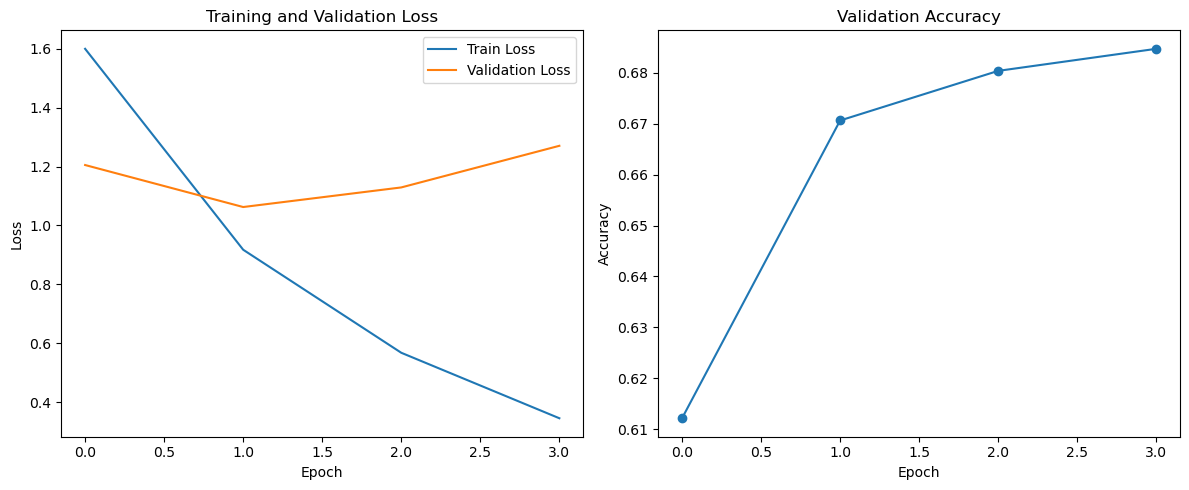

Model saved to bert_strategy_classifier


,utterance,strategy,confidence
0,Hello! Let's work together on a deal for these...,promote-coordination,0.704363
1,I need more water. What do you need?,elicit-pref,0.463830
2,I really need the firewood to keep warm.,self-need,0.887485
3,I see. What are you least interested in?,elicit-pref,0.855485


1. I think we're close. Let's shake hands on this: 3 firewood, 1 food for me, and then 2 food and 3 water for you. I'll make sure your food packages have extra doggy treats! 🙂 Is that a deal?
2. Hello. How are you?
3. I am good. I am pretty excited for the trip this weekend. what about you?
4. Very excited. It will be fun.
5. Yes, Hopefully the weather holds up. So I was thinking, i am bringning my two kids along with me, and they will need food, so I was thinking i could take the three foods, and either one of the firewood or water, up to you.
Evaluating strategy classifier performance...
Extracted 4615 utterances with strategy labels


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


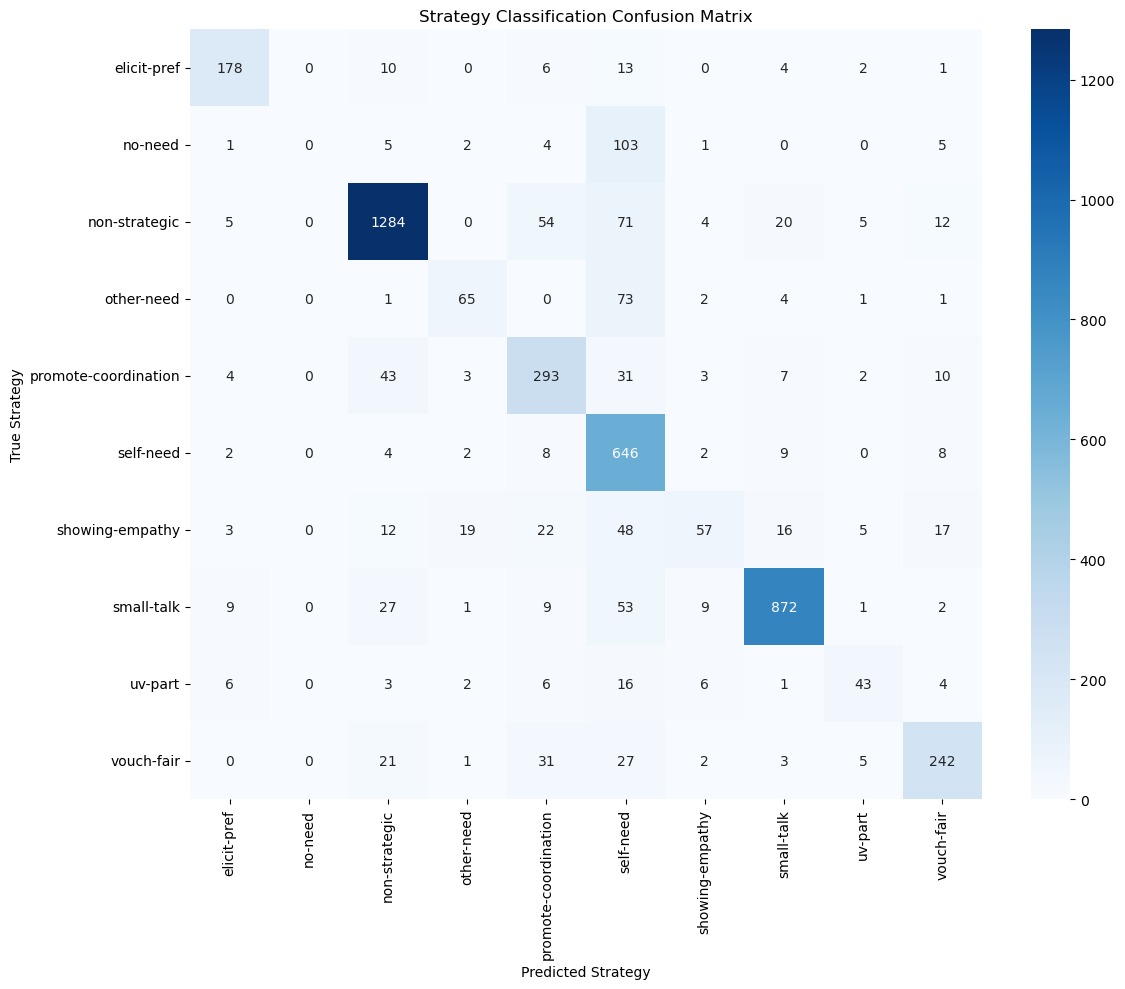


=== Strategy Classification Performance ===
       Model elicit-pref no-need non-strategic other-need promote-coordination self-need showing-empathy small-talk uv-part vouch-fair Overall
     BERT-SC       0.844   0.000         0.896      0.537                0.707     0.733           0.400      0.909   0.570      0.763   0.797
CaSiNo Paper       0.710   0.590         0.000      0.650                0.000     0.720           0.000      0.680   0.000      0.000   0.670
    Majority         0.0     0.0           0.0        0.0                  0.0       0.0             0.0        0.0     0.0        0.0   0.315


In [9]:
# 1. Initialize the classifier
classifier = StrategyClassifier(data=data)

# 2. Train the model (this will show progress bars and plots)
classifier.train(epochs=6, batch_size=8)

# 3. Save the trained model
classifier.save_model('bert_strategy_classifier')

# 4. Analyze examples
example_dialogue = """
Hello! Let's work together on a deal for these packages.
I need more water. What do you need?
I really need the firewood to keep warm.
I see. What are you least interested in?
"""

results = classifier.analyze_dialogue(example_dialogue)
display(results)

# 5. Get examples for a specific strategy -> Small Talk in this case
examples = classifier.get_strategy_examples('small-talk', n=5)
for i, example in enumerate(examples, 1):
    print(f"{i}. {example}")

# Evaluation
evaluation_results = evaluate_strategy_classifier(classifier)

In [10]:
# SVD-based Recommendation Function
def generate_svd_recommendations(strategy_recommender, user_personality, user_priorities):
    """Generate recommendations using SVD (Singular Value Decomposition)"""
    import numpy as np
    from scipy.sparse.linalg import svds
    
    print("\n=== SVD-Based Recommendations ===")
    
    if not hasattr(strategy_recommender, 'strategy_scores'):
        print("Strategy scores not found in recommender - can't generate SVD recommendations")
        return []
    
    # 1. Create a matrix of cluster × strategy scores
    clusters = sorted(strategy_recommender.strategy_scores.keys())
    all_strategies = sorted(set().union(*[s.keys() for s in strategy_recommender.strategy_scores.values()]))
    
    # Create matrix with cluster-strategy scores
    matrix = np.zeros((len(clusters), len(all_strategies)))
    for i, cluster in enumerate(clusters):
        for j, strategy in enumerate(all_strategies):
            matrix[i, j] = strategy_recommender.strategy_scores[cluster].get(strategy, 0)
    
    print(f"Created matrix with shape: {matrix.shape} (clusters × strategies)")
    
    # 2. Determine user's cluster
    user_vector = np.array([
        user_personality.get('extraversion', 0),
        user_personality.get('agreeableness', 0), 
        user_personality.get('conscientiousness', 0),
        user_personality.get('emotional-stability', 0),
        user_personality.get('openness-to-experiences', 0),
        2 if user_priorities.get('Food') == 'High' else (1 if user_priorities.get('Food') == 'Medium' else 0),
        2 if user_priorities.get('Water') == 'High' else (1 if user_priorities.get('Water') == 'Medium' else 0),
        2 if user_priorities.get('Firewood') == 'High' else (1 if user_priorities.get('Firewood') == 'Medium' else 0)
    ])
    
    # Find most similar cluster based on distance
    best_cluster_idx = 0
    best_similarity = -1
    
    for i, cluster in enumerate(clusters):
        # Get cluster centroid
        similar_items = [item for item in strategy_recommender.data if item.get('cluster') == cluster]
        if not similar_items:
            continue
            
        centroid = np.zeros(8)
        for item in similar_items:
            personality = item['personality']
            priorities = item['priorities']
            vector = [
                personality.get('extraversion', 0),
                personality.get('agreeableness', 0),
                personality.get('conscientiousness', 0),
                personality.get('emotional-stability', 0),
                personality.get('openness-to-experiences', 0),
                2 if priorities.get('Food') == 'High' else (1 if priorities.get('Food') == 'Medium' else 0),
                2 if priorities.get('Water') == 'High' else (1 if priorities.get('Water') == 'Medium' else 0),
                2 if priorities.get('Firewood') == 'High' else (1 if priorities.get('Firewood') == 'Medium' else 0)
            ]
            centroid += np.array(vector)
        
        centroid /= len(similar_items)
        
        # Calculate similarity
        similarity = 1 / (1 + np.linalg.norm(centroid - user_vector))
        if similarity > best_similarity:
            best_similarity = similarity
            best_cluster_idx = i
    
    print(f"User most closely matches cluster {clusters[best_cluster_idx]} (similarity: {best_similarity:.2f})")
    
    # 3. SVD-based recommendation
    # Apply SVD
    k = min(3, min(matrix.shape)-1)  # Number of latent factors
    U, sigma, Vt = svds(matrix, k=k)
    
    # Reconstruct the matrix
    sigma_diag = np.diag(sigma)
    svd_reconstructed = U.dot(sigma_diag).dot(Vt)
    
    # Get SVD-based recommendations for the user's cluster
    svd_scores = svd_reconstructed[best_cluster_idx]
    svd_recommendations = [(all_strategies[i], score) for i, score in enumerate(svd_scores)]
    svd_recommendations.sort(key=lambda x: x[1], reverse=True)
    
    # Print recommendations
    print("\nSVD Recommendations:")
    for strategy, score in svd_recommendations[:3]:
        print(f"  {strategy}: {score:.2f}")
    
    return svd_recommendations[:3]

In [11]:
!pip install implicit

In [12]:
def generate_als_recommendations(strategy_recommender, user_personality, user_priorities):
    """Generate recommendations using ALS (Alternating Least Squares)"""
    import numpy as np
    from scipy import sparse
    from implicit.als import AlternatingLeastSquares
    try:
        import threadpoolctl  # For controlling OpenBLAS threads
    except ImportError:
        pass  # If not available, we'll proceed without it
    
    print("\n=== ALS-Based Recommendations ===")
    
    if not hasattr(strategy_recommender, 'strategy_scores'):
        print("Strategy scores not found in recommender - can't generate ALS recommendations")
        return []
    
    # 1. Create a matrix of cluster × strategy scores
    clusters = sorted(strategy_recommender.strategy_scores.keys())
    all_strategies = sorted(set().union(*[s.keys() for s in strategy_recommender.strategy_scores.values()]))
    
    # Create matrix with cluster-strategy scores
    matrix = np.zeros((len(clusters), len(all_strategies)))
    for i, cluster in enumerate(clusters):
        for j, strategy in enumerate(all_strategies):
            matrix[i, j] = strategy_recommender.strategy_scores[cluster].get(strategy, 0)
    
    # Find valid strategies (those with non-zero scores in any cluster)
    valid_strategy_indices = []
    valid_strategies = []
    for j, strategy in enumerate(all_strategies):
        if np.sum(matrix[:, j]) > 0:
            valid_strategy_indices.append(j)
            valid_strategies.append(strategy)
    
    # If we have too few valid strategies, just use original recommendations
    if len(valid_strategies) < 3:
        print("Warning: Too few valid strategies for ALS recommendation")
        best_strategies = sorted([(s, np.max(matrix[:, j])) for j, s in enumerate(all_strategies) 
                                 if np.max(matrix[:, j]) > 0], 
                                key=lambda x: x[1], reverse=True)
        return best_strategies[:3]
    
    # Filter the matrix to only include valid strategies
    filtered_matrix = matrix[:, valid_strategy_indices]
    print(f"Filtered to {len(valid_strategies)} valid strategies with non-zero scores")
    
    # Check if the matrix is too sparse
    sparsity = 1.0 - (np.count_nonzero(filtered_matrix) / filtered_matrix.size)
    if sparsity > 0.9:
        print(f"Warning: Matrix is very sparse ({sparsity:.2%} zeros), ALS may not perform well")
    
    print(f"Created matrix with shape: {matrix.shape} (clusters × strategies)")
    
    # 2. Determine user's cluster
    user_vector = np.array([
        user_personality.get('extraversion', 0),
        user_personality.get('agreeableness', 0), 
        user_personality.get('conscientiousness', 0),
        user_personality.get('emotional-stability', 0),
        user_personality.get('openness-to-experiences', 0),
        2 if user_priorities.get('Food') == 'High' else (1 if user_priorities.get('Food') == 'Medium' else 0),
        2 if user_priorities.get('Water') == 'High' else (1 if user_priorities.get('Water') == 'Medium' else 0),
        2 if user_priorities.get('Firewood') == 'High' else (1 if user_priorities.get('Firewood') == 'Medium' else 0)
    ])
    
    # Find most similar cluster based on distance
    best_cluster_idx = 0
    best_similarity = -1
    
    for i, cluster in enumerate(clusters):
        # Get cluster centroid
        similar_items = [item for item in strategy_recommender.data if item.get('cluster') == cluster]
        if not similar_items:
            continue
            
        centroid = np.zeros(8)
        for item in similar_items:
            personality = item['personality']
            priorities = item['priorities']
            vector = [
                personality.get('extraversion', 0),
                personality.get('agreeableness', 0),
                personality.get('conscientiousness', 0),
                personality.get('emotional-stability', 0),
                personality.get('openness-to-experiences', 0),
                2 if priorities.get('Food') == 'High' else (1 if priorities.get('Food') == 'Medium' else 0),
                2 if priorities.get('Water') == 'High' else (1 if priorities.get('Water') == 'Medium' else 0),
                2 if priorities.get('Firewood') == 'High' else (1 if priorities.get('Firewood') == 'Medium' else 0)
            ]
            centroid += np.array(vector)
        
        centroid /= len(similar_items)
        
        # Calculate similarity
        similarity = 1 / (1 + np.linalg.norm(centroid - user_vector))
        if similarity > best_similarity:
            best_similarity = similarity
            best_cluster_idx = i
    
    print(f"User most closely matches cluster {clusters[best_cluster_idx]} (similarity: {best_similarity:.2f})")
    
    # 3. ALS-based recommendation with improvements
    # Set a fixed random seed for reproducibility
    np.random.seed(42)
    
    # Clone the matrix to avoid modifying the original
    matrix_for_als = filtered_matrix.copy()
    
    # Add very small random noise to break ties (much smaller than before)
    matrix_for_als += np.random.normal(0, 0.0001, matrix_for_als.shape)
    
    # Normalize the matrix to avoid scale issues
    row_max = np.max(matrix_for_als, axis=1, keepdims=True)
    # Avoid division by zero
    row_max[row_max == 0] = 1.0
    matrix_norm = matrix_for_als / row_max
    
    # Convert to sparse matrix for ALS
    sparse_matrix = sparse.csr_matrix(matrix_norm)
    
    # Set parameters for ALS
    als_params = {
        'factors': min(3, min(filtered_matrix.shape) - 1),
        'iterations': 50,
        'regularization': 0.1,
        'alpha': 1.0,
        'calculate_training_loss': True,
        'use_gpu': False
    }
    
    # Define a function to handle ALS training with thread control
    def train_als_model(sparse_matrix):
        try:
            # Try using threadpoolctl if available
            if 'threadpoolctl' in globals():
                with threadpoolctl.threadpool_limits(limits=1, user_api='blas'):
                    model = AlternatingLeastSquares(**als_params)
                    model.fit(sparse_matrix.T, show_progress=True)
            else:
                model = AlternatingLeastSquares(**als_params)
                model.fit(sparse_matrix.T, show_progress=True)
            return model
        except Exception as e:
            print(f"Warning: Error during ALS model training: {e}")
            # Create a reduced model as fallback
            reduced_params = {**als_params, 'factors': 2, 'iterations': 30}
            model = AlternatingLeastSquares(**reduced_params)
            model.fit(sparse_matrix.T, show_progress=True)
            return model
    
    # Train the ALS model
    als_model = train_als_model(sparse_matrix)
    
    # Get factors - this is where we need to be careful with indices
    user_factors = als_model.user_factors
    item_factors = als_model.item_factors
    
    # Here's the fix: Make sure we use a valid index for the filtered data
    if best_cluster_idx >= len(user_factors):
        print(f"Warning: Cluster index {best_cluster_idx} is out of bounds for filtered data.")
        # Use a valid index instead (first cluster)
        best_cluster_idx = 0
    
    # Get ALS-based recommendations for the user's cluster
    cluster_vector = user_factors[best_cluster_idx]
    als_scores = cluster_vector.dot(item_factors.T)
    
    # If all scores are too close to zero, use a fallback approach
    if np.max(np.abs(als_scores)) < 1e-5:
        print("ALS produced zero or near-zero scores, using fallback recommendations")
        # Use original scores for valid strategies as fallback
        valid_matrix = matrix[:, valid_strategy_indices]
        als_scores = valid_matrix[best_cluster_idx]
    
    # Create initial recommendations from ALS scores
    als_recommendations = [(valid_strategies[i], score) for i, score in enumerate(als_scores)]
    
    # Blend with original scores to ensure alignment with real data
    for i in range(len(als_recommendations)):
        strategy, score = als_recommendations[i]
        
        # Get original score from the matched cluster
        j = all_strategies.index(strategy)
        original_score = matrix[best_cluster_idx, j]
        
        # Calculate weighted blend (70% ALS, 30% original)
        # This helps maintain connection to the original data
        blended_score = 0.7 * score + 0.3 * original_score
        
        als_recommendations[i] = (strategy, blended_score)
    
    # Ensure scores are positive by offsetting negative values
    min_score = min([score for _, score in als_recommendations])
    if min_score < 0:
        als_recommendations = [(strategy, score - min_score) for strategy, score in als_recommendations]
    
    # Scaled to make values more readable
    max_score = max([score for _, score in als_recommendations]) if als_recommendations else 1.0
    if max_score > 0:
        als_recommendations = [(strategy, score / max_score * 20) for strategy, score in als_recommendations]
    
    # Sort by score
    als_recommendations.sort(key=lambda x: x[1], reverse=True)
    
    # Print results
    print("\nALS Recommendations:")
    for strategy, score in als_recommendations[:3]:
        print(f"  {strategy}: {score:.2f}")
    
    return als_recommendations[:3]

In [16]:
example_dialogue = """
Hello! Let's work together on a deal for these packages.
I need more water. What do you need?
I really need the firewood to keep warm.
I see. What are you least interested in?
"""

results = classifier.analyze_dialogue(example_dialogue)
display(results)  # DataFrame with predictions

# Examples of specific strategies
strategies_to_explore = ['small-talk', 'self-need', 'elicit-pref']
for strategy in strategies_to_explore:
    print(f"\nExamples of '{strategy}' strategy:")
    examples = classifier.get_strategy_examples(strategy, n=3)
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")

# Analyze strategy effectiveness from the dataset
strategy_effectiveness_data = analyze_strategy_effectiveness(data)

def print_raw_feature_matrix(recommender, rows=10):
    """Print the raw feature matrix without using pandas"""
    if hasattr(recommender, 'X') and hasattr(recommender, 'y'):
        # Create column names for better readability
        cols = [
            'extrav', 'agree', 'consc', 
            'emot-stab', 'open',
            'food', 'water', 'fire'
        ]
        
        print(f"\n=== Feature Matrix (first {rows} rows) ===")
        
        # Print header
        header = "ID  | " + " | ".join(f"{col:8s}" for col in cols) + " | points"
        print(header)
        print("-" * len(header))
        
        # Print rows
        for i in range(min(rows, len(recommender.X))):
            row = f"{i:3d} | "
            row += " | ".join(f"{val:8.2f}" for val in recommender.X[i])
            row += f" | {recommender.y[i]:6d}"
            print(row)
        
        print(f"\nTotal matrix shape: {recommender.X.shape} (rows × features)")
    else:
        print("Feature matrix not found in the recommender")

def print_feature_matrix_stats(recommender):
    """Print statistics about the feature matrix"""
    import numpy as np
    
    if hasattr(recommender, 'X') and hasattr(recommender, 'y'):
        # Feature names
        cols = [
            'extraversion', 'agreeableness', 'conscientiousness', 
            'emotional-stability', 'openness-to-experiences',
            'food_priority', 'water_priority', 'firewood_priority'
        ]
        
        print("\n=== Feature Matrix Statistics ===")
        
        # Matrix dimensions
        print(f"Feature Matrix Shape: {recommender.X.shape}")
        print(f"Total Samples: {len(recommender.X)}")
        
        # Feature statistics
        print("\nFeature Means:")
        means = np.mean(recommender.X, axis=0)
        for i, col in enumerate(cols):
            print(f"  {col}: {means[i]:.2f}")
            
        print("\nFeature Ranges:")
        min_vals = np.min(recommender.X, axis=0)
        max_vals = np.max(recommender.X, axis=0)
        for i, col in enumerate(cols):
            print(f"  {col}: {min_vals[i]:.1f} to {max_vals[i]:.1f}")
            
        # Points statistics
        print(f"\nPoints: Mean = {np.mean(recommender.y):.2f}, Min = {np.min(recommender.y)}, Max = {np.max(recommender.y)}")
        
        # Calculate correlations
        correlations = []
        for i in range(recommender.X.shape[1]):
            correlation = np.corrcoef(recommender.X[:, i], recommender.y)[0, 1]
            correlations.append((cols[i], correlation))
        
        # Sort correlations
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print("\nFeatures Correlation with Points (strongest first):")
        for feature, corr in correlations:
            print(f"  {feature}: {corr:.2f}")
    else:
        print("Feature matrix not found in the recommender")

def inspect_strategy_recommender(recommender):
    """Inspect the internals of the StrategyRecommender after it's fully initialized"""
    print("\n=== STRATEGY RECOMMENDER INSPECTION ===")
    
    # 1. Feature Vectors
    if hasattr(recommender, 'X') and hasattr(recommender, 'y'):
        print("\nFeature Vector Examples:")
        for i in range(min(3, len(recommender.X))):
            print(f"Sample {i+1}:")
            print(f"  Personality traits: {recommender.X[i][:5]}")  # First 5 are personality traits
            print(f"  Priorities: {recommender.X[i][5:]}") # Last 3 are priorities
            print(f"  Target points: {recommender.y[i]}")
    else:
        print("\nFeature vectors (X, y) not found in the recommender.")
    
    # 2. Strategy Effectiveness Matrix
    if hasattr(recommender, 'strategy_scores'):
        print("\nStrategy Effectiveness by Personality Cluster:")
        sample_clusters = list(recommender.strategy_scores.keys())[:3]
        for cluster in sample_clusters:
            print(f"Personality Cluster {cluster}:")
            for strategy, score in recommender.strategy_scores[cluster].items():
                if score > 0:  # If there are points for this strategy
                    print(f"  {strategy}: {score:.2f} points")
                    
        # If you also want to see the detailed data:
        print("\nDetailed Strategy Data (points and counts):")
        sample_clusters = list(recommender.cluster_strategy_effectiveness.keys())[:2]
        for cluster in sample_clusters:
            print(f"Cluster {cluster} (sample data):")
            for strategy, data in list(recommender.cluster_strategy_effectiveness[cluster].items())[:3]:
                print(f"  {strategy}: {data['points']} (count: {data['count']})")
    else:
        print("\nStrategy effectiveness data not found with expected names.")
        print("Available attributes:", [attr for attr in dir(recommender) if not attr.startswith('_')])
    
    print("\n=== END OF INSPECTION ===\n")

def print_strategy_matrix(recommender):
    """Print the strategy effectiveness matrix in a readable format"""
    if hasattr(recommender, 'strategy_scores'):
        print("\n=== Strategy Effectiveness Matrix ===")
        
        # Get all strategies
        all_strategies = set()
        for strategies in recommender.strategy_scores.values():
            all_strategies.update(strategies.keys())
        all_strategies = sorted(all_strategies)
        
        # Print header
        header = "Cluster | " + " | ".join(f"{strategy[:10]}" for strategy in all_strategies)
        print(header)
        print("-" * len(header))
        
        # Print each row
        for cluster, strategies in recommender.strategy_scores.items():
            row = f"{cluster:7d} | "
            row += " | ".join(f"{strategies.get(strategy, 0):8.2f}" for strategy in all_strategies)
            print(row)
        
        # Show best strategy for each cluster
        print("\nBest Strategy per Cluster:")
        for cluster, strategies in recommender.strategy_scores.items():
            if strategies:
                best_strategy = max(strategies.items(), key=lambda x: x[1])
                print(f"Cluster {cluster}: {best_strategy[0]} ({best_strategy[1]:.2f} points)")
    else:
        print("Strategy scores not found in the recommender")

# Initialize the strategy recommender
strategy_recommender = StrategyRecommender(strategy_effectiveness_data)
recommender = NegotiationRecommender(data)

# Printing matrix consisting of feature vectors
print_raw_feature_matrix(strategy_recommender, rows=10)
print_feature_matrix_stats(strategy_recommender)

# Inspecting strategy after everything is initialized
inspect_strategy_recommender(strategy_recommender)

# Matrix representation
print_strategy_matrix(strategy_recommender)

# Test with a sample user profile
sample_user = {
    'personality': {
        'extraversion': 4.5,
        'agreeableness': 6.0, 
        'conscientiousness': 5.5,
        'emotional-stability': 4.0,
        'openness-to-experiences': 5.5
    },
    'priorities': {
        'Food': 'High',
        'Water': 'Medium',
        'Firewood': 'Low'
    }
}

# Get recommendations for the sample user
print("\n=== Original Recommendations ===")
recommendations = recommender.get_recommendations(
    sample_user['personality'], 
    sample_user['priorities']
)

# Display recommendations
print("\n=== Recommended Negotiation Strategies ===\n")
for i, rec in enumerate(recommendations, 1):
    print(f"Strategy #{i}: {rec['strategy']}")
    print(f"Expected Points: {rec['expected_points']:.2f}")
    print(f"Explanation: {rec['explanation']}")
    print("Examples:")
    for j, example in enumerate(rec['examples'], 1):
        print(f"  {j}. \"{example}\"")
    print()

### GET RECOMMENDATIONS HERE AND COMPARE ALL ####
recommendations = recommender.get_recommendations(
    sample_user['personality'], 
    sample_user['priorities']
)

svd_recs = generate_svd_recommendations(
    strategy_recommender,
    sample_user['personality'],
    sample_user['priorities']
)

# als_recs = generate_als_recommendations(
#     strategy_recommender,
#     sample_user['personality'],
#     sample_user['priorities']
# )

# Compare the recommendation approaches
# comparison_table = compare_recommendation_approaches(recommendations, svd_recs, als_recs)
comparison_table = compare_recommendation_approaches(recommendations, svd_recs, svd_recs)

# Compare all approaches
print("\n=== Comparison of All Approaches ===")
print("Original Recommender:")
for rec in recommendations:
    print(f"  {rec['strategy']}: {rec['expected_points']:.2f}")

print("\nSVD Recommender:")
for strategy, score in svd_recs:
    print(f"  {strategy}: {score:.2f}")

# print("\nALS Recommender:")
# for strategy, score in als_recs:
#     print(f"  {strategy}: {score:.2f}")

,utterance,strategy,confidence
0,Hello! Let's work together on a deal for these...,promote-coordination,0.704363
1,I need more water. What do you need?,elicit-pref,0.463830
2,I really need the firewood to keep warm.,self-need,0.887485
3,I see. What are you least interested in?,elicit-pref,0.855485



Examples of 'small-talk' strategy:
1. I think we're close. Let's shake hands on this: 3 firewood, 1 food for me, and then 2 food and 3 water for you. I'll make sure your food packages have extra doggy treats! 🙂 Is that a deal?
2. Hello. How are you?
3. I am good. I am pretty excited for the trip this weekend. what about you?

Examples of 'self-need' strategy:
1. I am very excited, I'm actually going camping in a week. I drink a lot of water so it's important that I bring a lot. What about you?
2. I really am! I have been watching the weather and updates about the area I will be traveling to.  They are experiencing a severe drought, so I will be in need of some extra water as well! I planned on staying an extra couple days as well.  There is a stream nearby I believe, but I'm not sure how much it has dried up.
3. Let me think on that. I know there won't be much for berries or small animals to hunt for.  Is where you are going have much available for you to hunt and scavenge for?

Examp

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated strategy effectiveness for 8 personality clusters
Initializing Negotiation Recommender...
Extracted data from 2060 participants

=== Sample Feature Vectors (Personality + Priorities) ===
Sample 1:
  Personality traits: [5.  6.  6.  5.  5.5]
  Priorities: [1. 0. 2.]
  Associated points: 19
Sample 2:
  Personality traits: [4.  6.  5.5 3.  7. ]
  Priorities: [0. 1. 2.]
  Associated points: 18
Sample 3:
  Personality traits: [1. 7. 5. 7. 6.]
  Priorities: [2. 0. 1.]
  Associated points: 17




/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated strategy effectiveness for 8 personality clusters
Negotiation Recommender initialized successfully!

=== Feature Matrix (first 10 rows) ===
ID  | extrav   | agree    | consc    | emot-stab | open     | food     | water    | fire     | points
-----------------------------------------------------------------------------------------------------
  0 |     5.00 |     6.00 |     6.00 |     5.00 |     5.50 |     1.00 |     0.00 |     2.00 |     19
  1 |     4.00 |     6.00 |     5.50 |     3.00 |     7.00 |     0.00 |     1.00 |     2.00 |     18
  2 |     1.00 |     7.00 |     5.00 |     7.00 |     6.00 |     2.00 |     0.00 |     1.00 |     17
  3 |     3.50 |     4.50 |     6.00 |     6.50 |     6.50 |     2.00 |     0.00 |     1.00 |     19
  4 |     1.00 |     1.50 |     5.00 |     4.50 |     6.50 |     0.00 |     2.00 |     1.00 |     23
  5 |     5.00 |     7.00 |     7.00 |     5.00 |     7.00 |     1.00 |     2.00 |     0.00 |     14
  6 |     2.00 |     5.00 |     6.50 | 